### Louis-Antoine LeBel
#### ID: 40175005
#### COMP 333
#### Lab Assignment 3

#### Task Description
The purpose of this assignment is to recreate the data wrangling done in openrefine for the lab 8

In [184]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import phonetics


#### Text Facet

Function to generate a text facet. Entries can be sorted either alphabetically or by count.

In [185]:
def text_facet(col, sort = 'alphabetical'):
    if sort == 'count':
        col = col.groupby([col]).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
    else:
        col = col.groupby([col]).size().reset_index(name='counts')
    print(col)

#### Numeric Facet

The numeric facet function creates a histogram from the numeric entries. The function can take the log of the entries and can accept a range for the values

In [186]:
def numeric_facet(col, log = False, start = None, end = None):
    
    # determine range of histogram (and apply log if necessary)
    if start == None:
        start = np.log(col.min()) if log else col.min()
    if end == None:
        end = np.log(col.max()) if log else col.max()

    # in case start is nan (negative minimum)
    if np.isnan(start):
        start = 0
    if np.isnan(end):
        end = 0

    # create histogram
    if log:

        plt.hist(np.log(col), range=(start, end))
        plt.xlabel('log({})'.format(col.name))
    else:
        plt.hist(col, range = (start, end))
        plt.xlabel(col.name)

    # add y label
    plt.ylabel('Count')

#### Clustering

In order to emulate the lab exercise as closely as possible, I chose to use metaphone for clustering (although openrefine uses metaphone3). The function also prints which entries get changed for their cluster's value.

In [187]:

def cluster_metaphone(col):
    feature = col.name # name of column passed to the function
    col = col.astype("string").fillna('') # pre-process

    meta = [] # array to hold value of metaphone
    for s in col:
        meta.append(phonetics.metaphone(s)) # get cluster
    temp_df = pd.concat([col, pd.Series(meta, name='cluster')], axis=1) # temporary df to hold text entry with associated cluster 

    cluster_counts = temp_df[['cluster', feature]].value_counts() # pd series which sorts cluster by most common string within them

    # get all unique clusters and most common (correct) string within it
    max_cluster = {} # cluster centers
    to_change = {} # values to change
    for c in cluster_counts.index:
        if c[0] not in max_cluster.keys():
            max_cluster[c[0]] = c[1]
        else:
            if c[0] not in to_change.keys():
                to_change[c[0]] = [c[1]]
            else:
                to_change[c[0]].append(c[1])

    # print clusters where entries are being changed to their cluster centers
    print('Entries to change:')
    for cluster in to_change.keys():
        print('Cluster:', cluster)
        print('\t\033[1m{} ({} rows)\033[0m'.format(max_cluster[cluster], cluster_counts[cluster, max_cluster[cluster]]))
        for string in to_change[cluster]:
            print('\t{} ({} rows)'.format(string, cluster_counts[cluster, string]))

    return col.map(lambda x: max_cluster[phonetics.metaphone(x)]) # return clustered entries




#### Trimming

The trimming function is just a map function that strips every element in the dataframe that's a string

In [188]:
def strip_df(df):
    return df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#### Internal whitespace

In [189]:
def remove_internal_ws(df):
    return df.applymap(lambda x: re.sub(' +', ' ', x) if isinstance(x, str) else x)

### Data Wrangling

In [190]:
data = pd.read_csv('Portal_rodents_19772002_scinameUUIDs.csv', encoding = "ISO-8859-1")
data

C:\Users\louis\AppData\Local\Temp\ipykernel_16464\3935742010.py:1: DtypeWarning: Columns (11,12,13,16,17,18,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Portal_rodents_19772002_scinameUUIDs.csv', encoding = "ISO-8859-1")


,survey_id,recordID,mo,dy,yr,period,plot_id,plot,note1,stake,...,tag,note2,ltag,note3,prevrt,prevlet,nestdir,neststk,note4,note5
0,491ec41b-0a80-4ce9-b754-2983c6f38e71,6545,9,18,1982,62.0,4dc16022-f28d-4b9d-9062-c7bc3ad43362,13,13.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f280bade-4e9b-447d-afe0-9e6d45e6bfb0,5220,1,24,1982,54.0,dcbbd373-c22e-46ef-ae8b-ad88f5cf7475,20,13.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2b1b4a8a-c3e9-4781-a5f9-18b081383876,18932,8,7,1991,162.0,1e87b11b-4795-4f41-bdff-2d5c4412be25,19,13.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
3,e98e66c4-514b-45f7-9d95-336c05a72b21,20588,1,24,1993,179.0,91829d58-c12e-47e8-ae31-185f46be21d2,12,13.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,768cdd0d-93bc-4c74-9dcd-d1ed48b7501e,7020,11,21,1982,63.0,f24f2db6-eadd-4de9-9d2f-95aea376c013,24,13.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35544,5e05640b-d193-482a-9e8d-10608f4e810b,35542,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,23.0,...,0F7659,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
35545,a6bbdcbb-2c0a-4d3f-85a0-62a73270a108,35543,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,77.0,...,701178,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
35546,67137ae7-0919-49c3-bd8f-4afda8162994,35544,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35547,2bcb411b-9e81-42f6-a8db-aff0f863b564,35547,12,31,2002,295.0,c85de67c-1590-4129-8953-0c530a565585,10,NaN,32.0,...,NaN,NaN,0,NaN,0.0,0.0,NaN,NaN,UT,NaN


Generate a text facet for species

In [191]:
text_facet(data['species'])

   species  counts
0       AB     303
1       AH     437
2       AS       2
3       BA      46
4       CB      50
5       CM      13
6       CQ      16
7       CS       1
8       CT       1
9       CU       1
10      CV       1
11      DM   10596
12      DO    3027
13      DS    2504
14      DX      40
15      OL    1006
16      OT    2249
17      OX      12
18      PB    2891
19      PC      39
20      PE    1299
21      PF    1597
22      PG       8
23      PH      32
24      PI       9
25      PL      36
26      PM     899
27      PP    3123
28      PU       5
29      PX       6
30      RF      75
31      RM    2609
32      RO       8
33      RX       2
34      SA      75
35      SC       1
36      SF      43
37      SH     147
38      SO      43
39      SS     248
40      ST       1
41      SU       5
42      UL       4
43      UP       8
44      UR      10
45      US       4
46      ZL       2


Now sort by count

In [192]:
text_facet(data['species'], sort='count')

   species  counts
11      DM   10596
27      PP    3123
12      DO    3027
18      PB    2891
31      RM    2609
13      DS    2504
16      OT    2249
21      PF    1597
20      PE    1299
15      OL    1006
26      PM     899
1       AH     437
0       AB     303
39      SS     248
37      SH     147
30      RF      75
34      SA      75
4       CB      50
3       BA      46
36      SF      43
38      SO      43
14      DX      40
19      PC      39
25      PL      36
23      PH      32
6       CQ      16
5       CM      13
17      OX      12
44      UR      10
24      PI       9
32      RO       8
43      UP       8
22      PG       8
29      PX       6
28      PU       5
41      SU       5
45      US       4
42      UL       4
2       AS       2
46      ZL       2
33      RX       2
40      ST       1
35      SC       1
8       CT       1
9       CU       1
10      CV       1
7       CS       1


Create a numeric facet for period

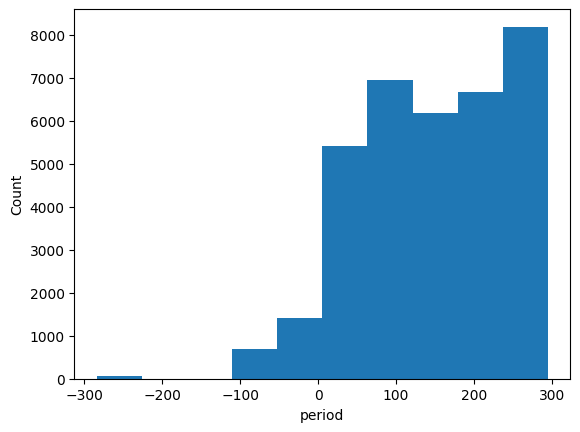

In [193]:
numeric_facet(data['period'])

Now take the log with recordID

C:\Users\louis\AppData\Local\Temp\ipykernel_16464\1280131780.py:5: RuntimeWarning: invalid value encountered in log
  start = np.log(col.min()) if log else col.min()
c:\Python310\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


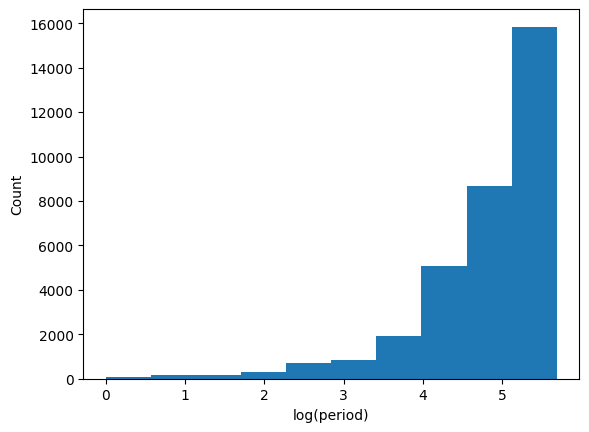

In [194]:
numeric_facet(data['period'], log = True)

Do a numeric facet on the years 1980 to 1995

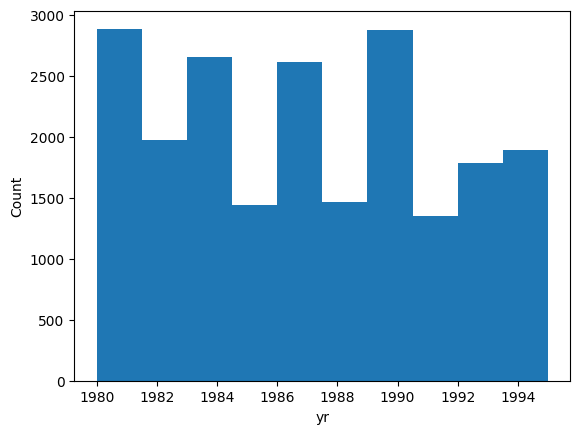

In [195]:
numeric_facet(data['yr'], start=1980, end=1995)

Trim every cell

In [196]:
data = strip_df(data)
data

,survey_id,recordID,mo,dy,yr,period,plot_id,plot,note1,stake,...,tag,note2,ltag,note3,prevrt,prevlet,nestdir,neststk,note4,note5
0,491ec41b-0a80-4ce9-b754-2983c6f38e71,6545,9,18,1982,62.0,4dc16022-f28d-4b9d-9062-c7bc3ad43362,13,13.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f280bade-4e9b-447d-afe0-9e6d45e6bfb0,5220,1,24,1982,54.0,dcbbd373-c22e-46ef-ae8b-ad88f5cf7475,20,13.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2b1b4a8a-c3e9-4781-a5f9-18b081383876,18932,8,7,1991,162.0,1e87b11b-4795-4f41-bdff-2d5c4412be25,19,13.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
3,e98e66c4-514b-45f7-9d95-336c05a72b21,20588,1,24,1993,179.0,91829d58-c12e-47e8-ae31-185f46be21d2,12,13.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,768cdd0d-93bc-4c74-9dcd-d1ed48b7501e,7020,11,21,1982,63.0,f24f2db6-eadd-4de9-9d2f-95aea376c013,24,13.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35544,5e05640b-d193-482a-9e8d-10608f4e810b,35542,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,23.0,...,0F7659,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
35545,a6bbdcbb-2c0a-4d3f-85a0-62a73270a108,35543,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,77.0,...,701178,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
35546,67137ae7-0919-49c3-bd8f-4afda8162994,35544,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35547,2bcb411b-9e81-42f6-a8db-aff0f863b564,35547,12,31,2002,295.0,c85de67c-1590-4129-8953-0c530a565585,10,NaN,32.0,...,NaN,NaN,0,NaN,0.0,0.0,NaN,NaN,UT,NaN


Since it is imposible to see any difference, I will use a small dataframe to showcase the trimming function

In [197]:
temp = pd.DataFrame({'Names' : ['                        Sunny','Bunny','Gin    ny ',' Binny ',' Chinni','Minni'],
                    'Age' : [23,44,23,54,22,11],
                    'Blood Group' : [' A+',' B+','O+','O-',' A-','B-'],
                   'Gender' : [' M',' M','F','F','F',' F']
                  })


print(temp)

                           Names  Age Blood Group Gender
0                          Sunny   23          A+      M
1                          Bunny   44          B+      M
2                     Gin    ny    23          O+      F
3                         Binny    54          O-      F
4                         Chinni   22          A-      F
5                          Minni   11          B-      F


In [198]:
temp = strip_df(temp)
print(temp)

       Names  Age Blood Group Gender
0      Sunny   23          A+      M
1      Bunny   44          B+      M
2  Gin    ny   23          O+      F
3      Binny   54          O-      F
4     Chinni   22          A-      F
5      Minni   11          B-      F


Remove internal white space

In [199]:
data = remove_internal_ws(data)
data

,survey_id,recordID,mo,dy,yr,period,plot_id,plot,note1,stake,...,tag,note2,ltag,note3,prevrt,prevlet,nestdir,neststk,note4,note5
0,491ec41b-0a80-4ce9-b754-2983c6f38e71,6545,9,18,1982,62.0,4dc16022-f28d-4b9d-9062-c7bc3ad43362,13,13.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f280bade-4e9b-447d-afe0-9e6d45e6bfb0,5220,1,24,1982,54.0,dcbbd373-c22e-46ef-ae8b-ad88f5cf7475,20,13.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2b1b4a8a-c3e9-4781-a5f9-18b081383876,18932,8,7,1991,162.0,1e87b11b-4795-4f41-bdff-2d5c4412be25,19,13.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
3,e98e66c4-514b-45f7-9d95-336c05a72b21,20588,1,24,1993,179.0,91829d58-c12e-47e8-ae31-185f46be21d2,12,13.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,768cdd0d-93bc-4c74-9dcd-d1ed48b7501e,7020,11,21,1982,63.0,f24f2db6-eadd-4de9-9d2f-95aea376c013,24,13.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35544,5e05640b-d193-482a-9e8d-10608f4e810b,35542,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,23.0,...,0F7659,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
35545,a6bbdcbb-2c0a-4d3f-85a0-62a73270a108,35543,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,77.0,...,701178,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
35546,67137ae7-0919-49c3-bd8f-4afda8162994,35544,12,31,2002,295.0,6a090985-a7ce-4c04-b146-9b401d1dd796,15,NaN,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35547,2bcb411b-9e81-42f6-a8db-aff0f863b564,35547,12,31,2002,295.0,c85de67c-1590-4129-8953-0c530a565585,10,NaN,32.0,...,NaN,NaN,0,NaN,0.0,0.0,NaN,NaN,UT,NaN


Again, I will showcase this function with a sample dataframe

In [200]:
remove_internal_ws(temp)

,Names,Age,Blood Group,Gender
0,Sunny,23,A+,M
1,Bunny,44,B+,M
2,Gin ny,23,O+,F
3,Binny,54,O-,F
4,Chinni,22,A-,F
5,Minni,11,B-,F


Cluster the species' scientificName

In [201]:
data['scientificName'] = cluster_metaphone(data['scientificName'])

Entries to change:
Cluster: AMFSPSPLNT
	Amphispiza bilineata (291 rows)
	Amphespiza bilineata (7 rows)
	Emphispiza bilinata (2 rows)
	Amphispizo bilineata (1 rows)
Cluster: AMSPRMFLSRS
	Ammospermophilus harrisi (435 rows)
	Ammospermophilus harrisii (1 rows)
	Ammospermophilis harrisi (1 rows)


Now if we check the unique values in that column, we can see that entries such as 'Ammospermophilus harrisi' are no longer present

In [202]:
data['scientificName'].unique()

array(['Amphispiza bilineata', 'Ammodramus savannarum',
       'Ammospermophilus harrisi', 'Amphispiza bilineatus',
       'Amphispiza cilineata', 'Baiomys taylori',
       'Calamospiza melanocorys', 'Callipepla squamata',
       'Campylorhynchus brunneicapillus', 'Chaetodipus baileyi',
       'Cnemidophorus tigris', 'Cnemidophorus uniparens',
       'Crotalus scutalatus', 'Crotalus viridis', 'Dipodomys merriami',
       'Dipodomys ordii', 'Dipodomys spectabilis', 'Dipodomys\xa0sp.',
       'Onychomys leucogaster', 'Onychomys torridus', 'Onychomys\xa0sp.',
       ''], dtype=object)